In [1]:
# !kaggle datasets download -d medharawat/google-stock-price

In [2]:
import shutil
shutil.unpack_archive("google-stock-price.zip", "./")

In [3]:
import numpy as np
import pandas as pd

# 데이터 로드
data = pd.read_csv("Google_Stock_Price_Train.csv")
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [4]:
# 필요한 열만 선택 (Date, Close)
data = data[['Date', 'Close']]

# Date 열을 datetime 형식으로 변환
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9148\1878749697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


,Close
Date,
2012-01-03,663.59
2012-01-04,666.45
2012-01-05,657.21
2012-01-06,648.24
2012-01-09,620.76


In [5]:
data['Close'] = data['Close'].str.replace(',', '').astype(float)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9148\745001292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = data['Close'].str.replace(',', '').astype(float)


In [6]:
# 시계열 데이터 생성 (종가 데이터)
data = data['Close'].values

In [7]:
data

array([663.59, 666.45, 657.21, ..., 785.05, 782.79, 771.82])

In [8]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

In [9]:
# 데이터 전처리 함수
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [10]:
# 시계열 데이터 생성
time_steps = 60
x, y = prepare_data(data, time_steps)

# 데이터 형태 변경
x = x.reshape((x.shape[0], x.shape[1], 1))

# 학습 데이터와 테스트 데이터 분리
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
import torch

# 데이터 텐서로 변환
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [13]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0974
Epoch [10/20], Loss: 0.0646
Epoch [15/20], Loss: 0.0630
Epoch [20/20], Loss: 0.0485


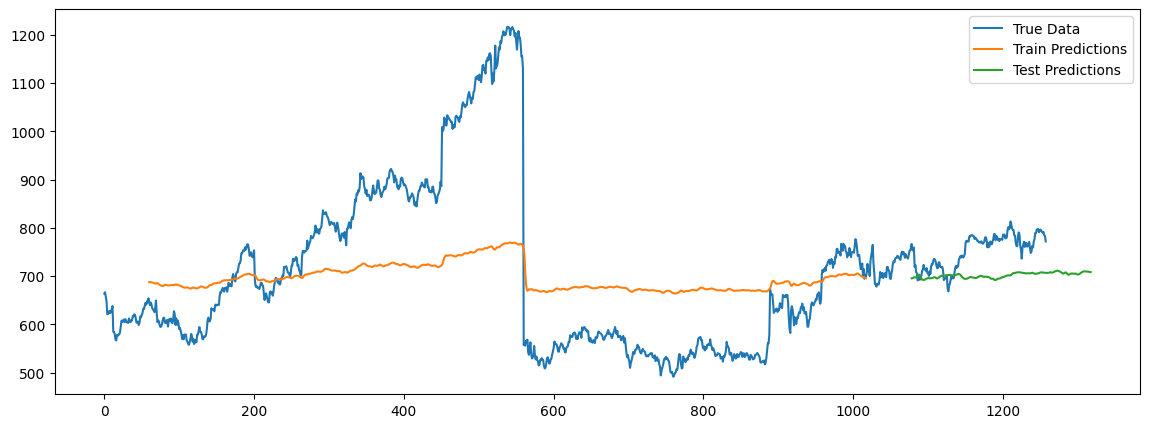

In [14]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 학습 데이터와 테스트 데이터에 대한 예측
train_predictions = model(x_train).detach().numpy()
test_predictions = model(x_test).detach().numpy()

# 예측값과 실제값의 스케일을 원래대로 되돌림
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 결과 시각화
plt.figure(figsize=(14, 5))

# 전체 데이터 시각화
plt.plot(scaler.inverse_transform(data), label='True Data')

# 학습 데이터에 대한 예측 시각화
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')

# 테스트 데이터에 대한 예측 시각화
plt.plot(np.arange(len(train_predictions) + 2 * time_steps, len(train_predictions) + 2 * time_steps + len(test_predictions)), test_predictions, label='Test Predictions')

plt.legend()
plt.show()